<a href="https://colab.research.google.com/github/Moaaz900/BBC-news-articles/blob/master/BBC-news-articles/Notebook/BBC%20articles%20classification/BBC_articles_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install huggingface transformer

In [ ]:
!pip install transformers
!pip install sentencepiece # reqiured for xlnet

# Import libraries and tokenizers 



In [ ]:
from transformers import BertTokenizer #Import Bert tokenizer from huggingface
from transformers import TFAutoModel # Import Bert models
from transformers import TFAutoModelForSequenceClassification,AutoTokenizer
#Import libraries 
import pandas as pd
import numpy as np
import tensorflow as tf # import tensorflow
#To save checkpoint of model 
import shutil
import sys
#plotly for visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
#scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab import drive
from keras.models import load_model
from time import time
from sklearn.utils.class_weight import compute_class_weight
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow import keras

# Check that we can connect to the TPUs

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

Running on TPU  ['10.75.88.242:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.75.88.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.88.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


# Check TF version and Eager mode

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())

TF Version:  2.7.0
Eager mode:  True


#Custom initialization for plotly on colab

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

# Download Tokenizers

In [ ]:
#Download Bert tokenizer 
Bert_tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
#Download XLNet tokenizer 
XLNet_tokenizer=AutoTokenizer.from_pretrained("xlnet-base-cased")

# Download Models

In [ ]:
# Download Bert model
Bert_layer=TFAutoModel.from_pretrained('bert-base-uncased') #uncased for lower case
#Download Xlnet layer
#cased for Upper case
XlNet_layer=TFAutoModelForSequenceClassification.from_pretrained("xlnet-base-cased",problem_type="multi_label_classification",num_labels=5)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you a

# Data Reading

In [ ]:
#Connect to google drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path='/content/drive/MyDrive/BBC News Train.csv'
test_path='/content/drive/MyDrive/BBC News Test.csv'
sub_sample_path='/content/drive/MyDrive/BBC News Sample Solution.csv'
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
train
sub_sample=pd.read_csv(sub_sample_path)
sub_sample

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


In [ ]:
test

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


#Functions

In [ ]:
 #function to group data by categories
def group(df,column):
  groupped_Category=df.groupby([column]).agg({column:'count'})
  groupped_Category.rename({column:'count_of_categories'},axis=1,inplace=True)
  groupped_Category=groupped_Category.reset_index()
  return groupped_Category

In [ ]:
 #Barplot function
def Barplot(category,values):
  configure_plotly_browser_state()
  fig = go.Figure([go.Bar(x=category,y=values,)])

  fig.update_layout(title_text='Categorical', yaxis_title ='Count',
                  xaxis_title='Categories',
                  xaxis={'categoryorder':'total ascending'})
  fig.show()

In [ ]:
# pieplot function
def pieplot(category,values): 
  configure_plotly_browser_state()
  fig = make_subplots(rows=1,cols=2,specs=[[{'type':'domain'},{'type':'domain'}]])
  fig.add_trace(go.Pie(labels=category,
                     values=values,),
                     row=1,col= 1)
  fig.show()


In [ ]:
#function to tokenize data
def tokenize(max_length,df,Text,label,Tokenizer): 
  #seq_len=512
  num_samples=len(df)

  Xids=np.zeros((num_samples,max_length))
  Xmask=np.zeros((num_samples,max_length))


  for i,Text in enumerate(df['Text']):
    tokens=Tokenizer.encode_plus(Text,
                                 max_length=max_length,
                                 truncation=True,
                                 padding='max_length',
                                 add_special_tokens=True,
                                 return_tensors='tf') 
                      
  
 # assign tokenized outputs to respective rows in numpy arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']


# first extract lables column
  arr = df.label.values

# we then initialize the zero array
  label= np.zeros((len(df),arr.max()+1))

# set relevant index for each row to 1 (one-hot encode)
  label[np.arange(len(df)),arr] = 1
  label
# create the dataset object
  dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,label))
  return dataset

* `tf.data.Datasets` return `(features, labels)` pairs, as 
expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# function to map inputs_ids and attention_mask
def map_func(input_ids, masks,labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [ ]:
# function to create tensorflow data pipeline
def pipeline(data,batch_size,shuffle): #Data shuffling
  data=data.shuffle(shuffle).batch(batch_size,drop_remainder=True)
  return data

In [ ]:
# function to plot metrics and loss
def plot_graphs(history, metric,model_name): 
  plt.title(model_name+' '+metric)
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train '+metric, 'val_'+metric])
  plt.savefig('/content/drive/MyDrive/plots/'+model_name+' '+metric+'.png')
  plt.show()

In [ ]:
 # function to predict news article categories
def prediction(df,label,model,tokenizer):
  classes_list=[]
  for Text in  df['Text']:# Data preparation as an input to bert model
    tokens=tokenizer.encode_plus(Text,max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    tokenizations={
                    'input_ids':tf.cast(tokens['input_ids'], tf.float64),
                   'attention_mask':tf.cast(tokens['attention_mask'], tf.float64),
                   }

    probabilities=model.predict(tokenizations)
    highest_class=np.argmax(probabilities)
    classes_list.append(highest_class)
  df[label]=classes_list
  inv_map = {v: k for k, v in label_dict.items()}
  df['category']=df.label.map(inv_map)
  return df 

In [ ]:
 # function to make a trials after model loading
def prep_data(text,tokenizer):
    # tokenize to get input IDs and attention mask 
  tokens=tokenizer.encode_plus(text,max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
  return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
          'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

# Data Cleaning

In [ ]:
#Check Nulls and duplications
print(train.isna().sum())
print(train['ArticleId'].duplicated().sum())

ArticleId    0
Text         0
Category     0
dtype: int64
0


In [ ]:
print(test.isna().sum())

ArticleId    0
Text         0
dtype: int64


In [ ]:
# Drop useless columns
#train.drop('ArticleId',inplace=True,axis=1)
#train.head()

# Data Visualization 






Categories distributions

In [ ]:
groupped_Category=group(train,'Category')
groupped_Category

,Category,count_of_categories
0,business,336
1,entertainment,273
2,politics,274
3,sport,346
4,tech,261


In [ ]:
Barplot(groupped_Category.Category,groupped_Category.count_of_categories)

In [ ]:
pieplot(groupped_Category.Category,groupped_Category.count_of_categories)

*    Sport category dominates the distribution
*    Classes are imbalance 

Words distribution in articles

In [ ]:
seq_len = [len(i.split()) for i in train['Text']]
configure_plotly_browser_state()
fig = px.histogram(x=seq_len,nbins=30)
fig.show()



*   peak 299.5
*   Bert maximum length tokenization is 512
*   I will use maximum length to 512  







# Data Preprocessing

Label encoding

In [ ]:
possible_labels = train.Category.unique()
possible_labels
label_dict = {}
for index,possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    #print(index,possible_label)
label_dict
train['label'] =train.Category.map(label_dict)
train

,ArticleId,Text,Category,label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,1


Data splitting



*   Assuming the population have the same distribution of classes 
*   Using the stratification sampling method to split data 



In [ ]:
  train_df,valid_df= train_test_split(train,random_state=42,train_size=0.80,stratify=train.Category.values,shuffle=True)
  train_df.shape,valid_df.shape                

((1192, 4), (298, 4))

In [ ]:
valid_df

,ArticleId,Text,Category,label
1439,1111,what high-definition will do to dvds first it ...,tech,1
815,301,stars pay tribute to actor davis hollywood sta...,entertainment,4
1403,595,roche turns down federer offer australian te...,sport,3
1360,165,ukip candidate suspended eurosceptic party uki...,politics,2
846,415,brown and blair face new rift claims for the u...,politics,2
...,...,...,...,...
6,651,wales silent on grand slam talk rhys williams ...,sport,3
954,679,oscar host rock to keep it clean oscar host ch...,entertainment,4
1105,1831,tough rules for ringtone sellers firms that fl...,tech,1
964,629,volcano drama erupts on bbc one supervolcano ...,entertainment,4


Categories distribution after splliting with stratification sampling method 

In [ ]:
groupped_Category_vaild=group(valid_df,'Category')
groupped_Category_train=group(train_df,'Category')

In [ ]:
pieplot(groupped_Category_vaild.Category,groupped_Category_vaild.count_of_categories)
pieplot(groupped_Category_train.Category,groupped_Category_train.count_of_categories)




* Classes have the same distribution in validation and traing as population data 







# Tokenize and Preprocess Text 

Bert architecture





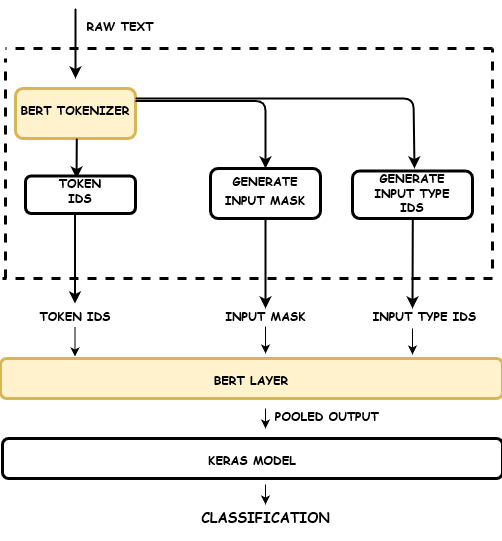

 Create tf.data.Datasets for Training and Evaluation

In [ ]:
dataset_train=tokenize(512,train_df,train_df.Text,train_df.label,Bert_tokenizer)
# then we use the dataset map method to apply this transformation
dataset_train=dataset_train.map(map_func)
print('shape of data set',dataset_train.take(1))

shape of data set <TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


In [ ]:
dataset_valid=tokenize(512,valid_df,valid_df.Text,valid_df.label,Bert_tokenizer)
# then we use the dataset map method to apply this transformation
dataset_valid =dataset_valid.map(map_func)
print('shape of data set',dataset_valid.take(1))

shape of data set <TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


Create a TensorFlow Input Pipeline with


In [ ]:
Train_dataset_Bert=pipeline(dataset_train,16,10000)
Valid_dataset_Bert=pipeline(dataset_valid,16,10000)
Train_dataset_Bert,Valid_dataset_Bert

(<BatchDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>,
 <BatchDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>)

# Model building

Classe weights

In [ ]:
#Calculate the classe weights
class_weights =compute_class_weight('balanced',classes=np.unique(train_df['label']),y=train_df['label'])
class_weights_dict ={}
for index,value in enumerate(class_weights):
  class_weights_dict[index] = value
class_weights_dict

{0: 0.8862453531598513,
 1: 1.14066985645933,
 2: 1.0885844748858446,
 3: 0.8606498194945849,
 4: 1.0935779816513762}



*   Tell the model to "pay more attention" to samples from an 
under-represented class.




Main blocks, add a Classification Head to Bert and XLNet Layers, metrics and loss :

In [ ]:
# Building the model
def creat_model(maximum_length,neurons,droupout_Rate,Categories_number,activation,learningRate,decay,layer):
  input_ids=tf.keras.layers.Input(shape=(maximum_length,),name="input_ids",dtype='int32')
  attention_mask=tf.keras.layers.Input(shape=(maximum_length,),name="attention_mask",dtype='int32')
  if layer==Bert_layer:
    pooled_out=layer.bert([input_ids,attention_mask])[1] #pooled out as input to activation layer
    net= tf.keras.layers.Dense(neurons,activation=activation)(pooled_out)
  else:
    last_hidden_state=layer([[input_ids,attention_mask]])[0]# Collect last step from last hidden state (CLS)
    net= tf.keras.layers.Dense(neurons,activation=activation)(last_hidden_state)

  net = tf.keras.layers.Dropout(droupout_Rate)(net) #helps prevent overfitting
  output= tf.keras.layers.Dense(Categories_number,activation='softmax',name='output')(net)
  model = tf.keras.Model(inputs=[input_ids,attention_mask],outputs=output)


  metric=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='Precision'),
  tf.keras.metrics.Recall(name='Recall'),
  tf.keras.metrics.TruePositives(name='TruePositives'),
  tf.keras.metrics.FalsePositives(name='FalsePositives')]
  optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate,decay=decay,) # literature recommend 3e-4, 1e-4, 5e-5, 3e-5
  loss = tf.keras.losses.CategoricalCrossentropy()#used for multi-class classification model where there are two or more output labels
  model.compile(optimizer=optimizer, loss=loss, metrics=metric)
  return model

# Bert

In [ ]:
Bert_Model=creat_model(512,1024,0.1,len(possible_labels),'gelu',5e-5,1e-6,Bert_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

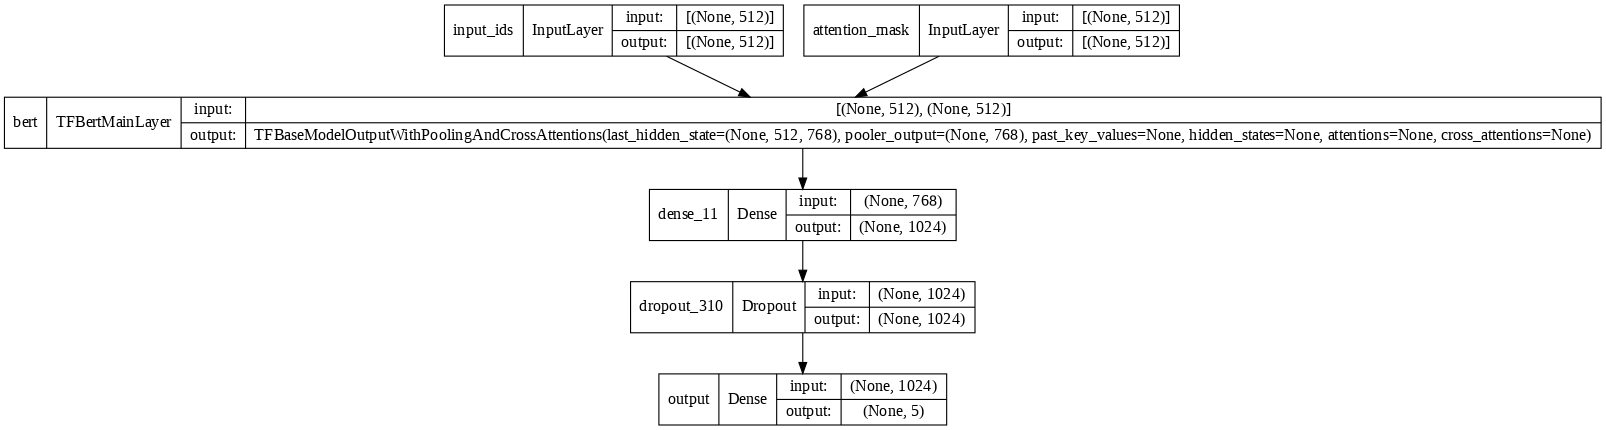

In [ ]:
tf.keras.utils.plot_model(model=Bert_Model, show_shapes=True, dpi=80, )

In [ ]:
# (optional) freeze bert layer
#model.layers[2].trainable = True

#Fine-Tune BERT for Articles Classification

Model fitting

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Check point bert'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    baseline=None,
    restore_best_weights=True,
    verbose=1
)

In [ ]:

start = time()
history=Bert_Model.fit(
    Train_dataset_Bert,
    validation_data=Valid_dataset_Bert, 
    class_weight=class_weights_dict,
    callbacks=[model_checkpoint_callback,EarlyStopping],
    epochs=4, # author recommend 2 to 4 further model will overfit
    verbose=1,
)
print((time()-start)/60)

Epoch 1/4
74/74 [==============================] - 888s 12s/step - loss: 0.1056 - accuracy: 0.9789 - Precision: 0.9805 - Recall: 0.9780 - TruePositives: 1158.0000 - FalsePositives: 23.0000 - val_loss: 0.2743 - val_accuracy: 0.9514 - val_Precision: 0.9514 - val_Recall: 0.9514 - val_TruePositives: 274.0000 - val_FalsePositives: 14.0000
Epoch 2/4
74/74 [==============================] - 900s 12s/step - loss: 0.0723 - accuracy: 0.9882 - Precision: 0.9890 - Recall: 0.9873 - TruePositives: 1169.0000 - FalsePositives: 13.0000 - val_loss: 0.2580 - val_accuracy: 0.9583 - val_Precision: 0.9583 - val_Recall: 0.9583 - val_TruePositives: 276.0000 - val_FalsePositives: 12.0000
Epoch 00002: early stopping
29.787503929932914


#Model Validation 

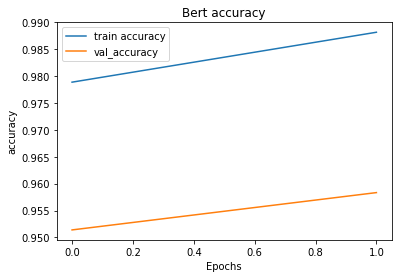

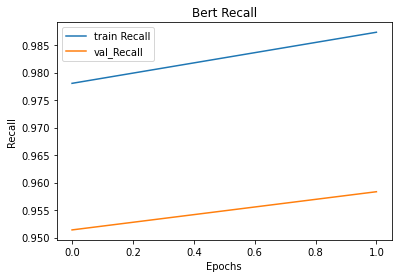

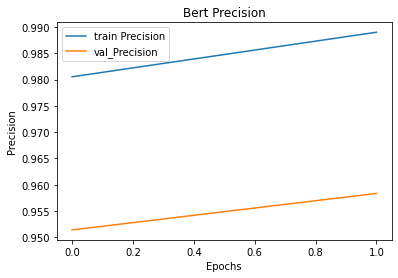

In [ ]:
plot_graphs(history,'accuracy','Bert')
plot_graphs(history,'Recall','Bert')
plot_graphs(history,'Precision','Bert')

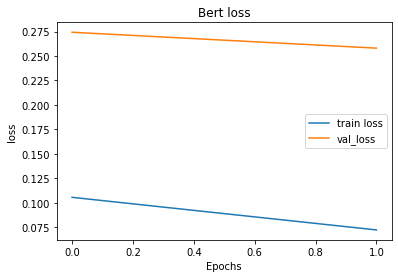

In [ ]:
plot_graphs(history,'loss','Bert')

In [ ]:
#Model evalution
Bert_Model.evaluate(Valid_dataset_Bert,verbose=1)

18/18 [==============================] - 103s 6s/step - loss: 0.2548 - accuracy: 0.9618 - Precision: 0.9618 - Recall: 0.9618 - TruePositives: 277.0000 - FalsePositives: 11.0000


[0.25476276874542236,
 0.9618055820465088,
 0.9618055820465088,
 0.9618055820465088,
 277.0,
 11.0]

# Unseen news article categories inference

In [ ]:
test_prediction_bert=prediction(test,'label',Bert_Model,Bert_tokenizer) # test data predictions 
test_prediction_bert

,ArticleId,Text,label,category
0,1018,qpr keeper day heads for preston queens park r...,3,sport
1,1319,software watching while you work software that...,1,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,3,sport
3,459,india s reliance family feud heats up the ongo...,0,business
4,1020,boro suffer morrison injury blow middlesbrough...,3,sport
...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,0,business
731,373,u2 to play at grammy awards show irish rock ba...,4,entertainment
732,1704,sport betting rules in spotlight a group of mp...,2,politics
733,206,alfa romeos to get gm engines fiat is to sto...,0,business


In [ ]:
# Save prediction as csv file to submit
test_prediction_bert.to_csv('/content/drive/MyDrive/Submission/BertSubmission.csv',index=False)

Bert submission
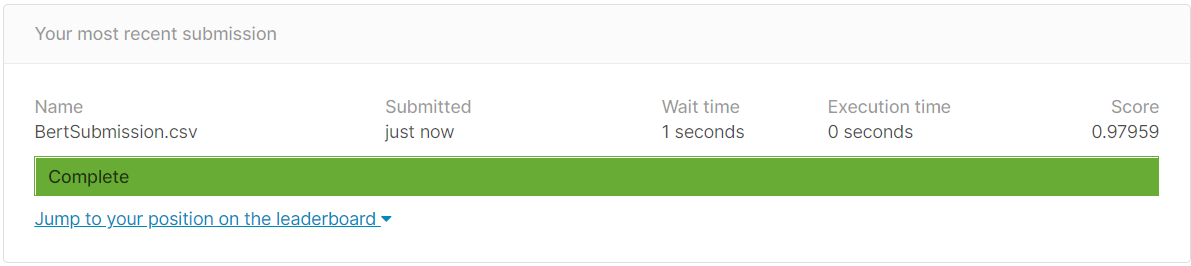

# Save and load fine-tuned Bert model 

In [ ]:
#Saving model to google drive 
Bert_Model.save('/content/drive/MyDrive/Models/BBC_Classification_with_bert.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
# returns a compiled model
# identical to the previous one
bertmodel=load_model('/content/drive/MyDrive/Models/BBC_Classification_with_bert.h5')

# Trial after model loading 

In [ ]:
tensor=prep_data('qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.',Bert_tokenizer)

probabilities=bertmodel.predict(tensor) 
classse=np.argmax(probabilities)
print(classse,probabilities)

3 [[8.92584794e-05 4.78130860e-05 1.16355506e-04 9.99609530e-01
  1.37094670e-04]]


# XLNet 

# Tokenize and Preprocess Text for XLNet

In [ ]:
dataset_train=tokenize(512,train_df,train_df.Text,train_df.label,XLNet_tokenizer)
# then we use the dataset map method to apply this transformation
dataset_train=dataset_train.map(map_func)
#for i in dataset_train.take(1):
 # print(i)
print('shape of data set',dataset_train.take(1))

shape of data set <TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


In [ ]:
dataset_valid=tokenize(512,valid_df,valid_df.Text,valid_df.label,XLNet_tokenizer)
# then we use the dataset map method to apply this transformation
dataset_valid=dataset_valid.map(map_func)
#for i in dataset_train.take(1):
 # print(i)
print('shape of data set',dataset_valid.take(1))


shape of data set <TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


 Create a TensorFlow Input Pipeline

In [ ]:
Train_dataset_XLNet=pipeline(dataset_train,8,100)
Valid_dataset_XLNet=pipeline(dataset_valid,8,100)                 

In [ ]:
XlNet_layer.summary()

Model: "tfxl_net_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFXLNetMainLay  multiple                 116718336 
 er)                                                             
                                                                 
 sequence_summary (TFSequenc  multiple                 590592    
 eSummary)                                                       
                                                                 
 logits_proj (Dense)         multiple                  3845      
                                                                 
Total params: 117,312,773
Trainable params: 117,312,773
Non-trainable params: 0
_________________________________________________________________


# Model building 

In [ ]:
XLNet_Model=creat_model(512,1024,0.1,len(possible_labels),'gelu',2e-5,1e-6,XlNet_layer)
XLNet_Model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tfxl_net_for_sequence_classifi  TFXLNetForSequenceC  117312773  ['input_ids[0][0]',              
 cation_3 (TFXLNetForSequenceCl  lassificationOutput              'attention_mask[0][0]']         
 assification)                  (loss=None, logits=                                               
                                (None, 5),                                                 

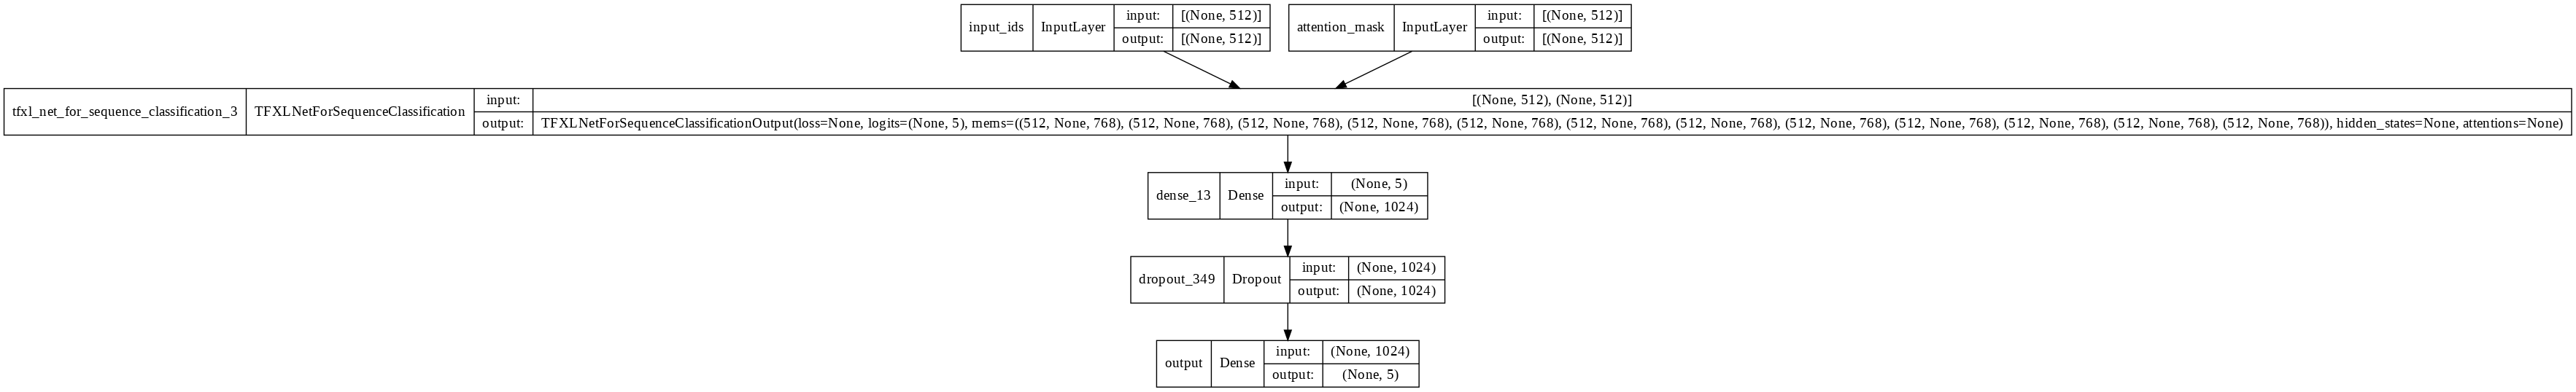

In [ ]:
tf.keras.utils.plot_model(model=XLNet_Model,to_file='model_xl.png',expand_nested=True,show_shapes=True, dpi=100 )

# Fine-Tune Xlnet for Articles Classification

Model training

In [ ]:
#Model training
start = time()
history=XLNet_Model.fit(
    Train_dataset_XLNet,
    validation_data=Valid_dataset_XLNet,
    class_weight=class_weights_dict,# tell the model to "pay more attention" to samples from an under-represented class.
    #callbacks=[EarlyStopping],
    epochs=4, # author recommend 2 to 4 further model will overfit
    verbose=1,
)
print((time()-start)/60)

Epoch 1/4
149/149 [==============================] - 1151s 8s/step - loss: 1.0078 - accuracy: 0.8213 - Precision: 0.9836 - Recall: 0.3012 - TruePositives: 359.0000 - FalsePositives: 6.0000 - val_loss: 0.5040 - val_accuracy: 0.9493 - val_Precision: 0.9583 - val_Recall: 0.9324 - val_TruePositives: 276.0000 - val_FalsePositives: 12.0000
Epoch 2/4
149/149 [==============================] - 1155s 8s/step - loss: 0.3492 - accuracy: 0.9631 - Precision: 0.9686 - Recall: 0.9589 - TruePositives: 1143.0000 - FalsePositives: 37.0000 - val_loss: 0.2508 - val_accuracy: 0.9561 - val_Precision: 0.9655 - val_Recall: 0.9459 - val_TruePositives: 280.0000 - val_FalsePositives: 10.0000
Epoch 3/4
149/149 [==============================] - 1147s 8s/step - loss: 0.1574 - accuracy: 0.9773 - Precision: 0.9797 - Recall: 0.9740 - TruePositives: 1161.0000 - FalsePositives: 24.0000 - val_loss: 0.1833 - val_accuracy: 0.9662 - val_Precision: 0.9728 - val_Recall: 0.9662 - val_TruePositives: 286.0000 - val_FalsePositiv

# XLNet Model Validation

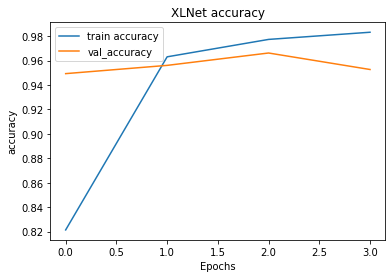

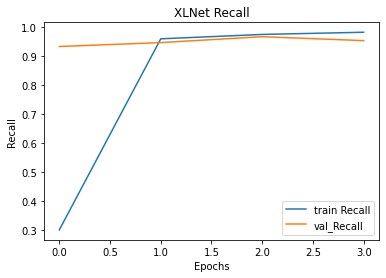

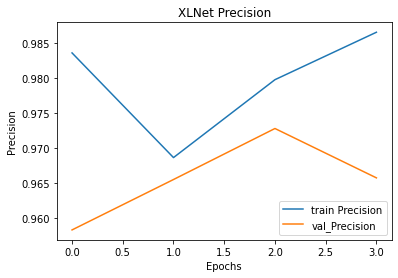

In [ ]:
plot_graphs(history,'accuracy','XLNet')
plot_graphs(history,'Recall','XLNet')
plot_graphs(history,'Precision','XLNet')

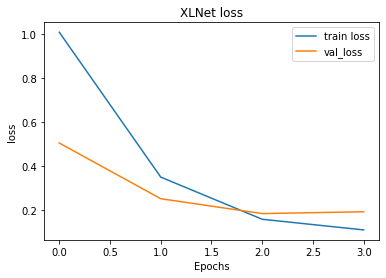

In [ ]:
plot_graphs(history,'loss','XLNet')

In [ ]:
XLNet_Model.evaluate(Valid_dataset_XLNet, verbose=1)

37/37 [==============================] - 67s 2s/step - loss: 0.1915 - accuracy: 0.9527 - Precision: 0.9658 - Recall: 0.9527 - TruePositives: 282.0000 - FalsePositives: 10.0000


[0.19154654443264008,
 0.9527027010917664,
 0.965753436088562,
 0.9527027010917664,
 282.0,
 10.0]

# Unseen news article categories inference

In [ ]:
test_prediction_xlnet=prediction(test,'label',XLNet_Model,XLNet_tokenizer)
test_prediction_xlnet

,ArticleId,Text,label,category
0,1018,qpr keeper day heads for preston queens park r...,3,sport
1,1319,software watching while you work software that...,1,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,3,sport
3,459,india s reliance family feud heats up the ongo...,0,business
4,1020,boro suffer morrison injury blow middlesbrough...,3,sport
...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,0,business
731,373,u2 to play at grammy awards show irish rock ba...,4,entertainment
732,1704,sport betting rules in spotlight a group of mp...,2,politics
733,206,alfa romeos to get gm engines fiat is to sto...,0,business


In [ ]:
test_prediction_xlnet.to_csv('/content/drive/MyDrive/Submission/xlnetsub.csv',index=False)

# Submission 

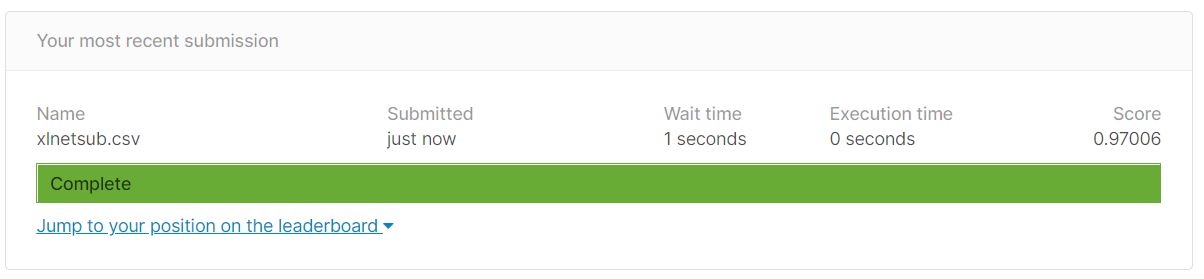

# Model saving

In [ ]:
#Saving the model to google drive 
XLNet_Model.save('/content/drive/MyDrive/Models/BBC_Classification with Xlnet.h5')  # creates a HDF5 file 'my_model.h5'

# Trial

In [ ]:
tensor=prep_data('india s reliance family feud heats up the ongoing public spat between the two heirs of india s biggest conglomerate  reliance group  has spilled over to the board meeting of a leading company within the group.  anil ambani  vice-chairman of india petrochemicals limited (ipcl)  stayed away from a gathering of senior managers on thursday. the move follows a decision earlier this month by anil - the younger brother of reliance group president mukesh ambani - to resign from his post. his resignation was not accepted by his brother  who is also the boss of ipcl. the ipcl board met in mumbai to discuss the company s results for the october-to-december quarter.  it is understood that the board also considered anil s resignation and asked him to reconsider his decision. however  anil s demand that anand jain - another ipcl board member accused by anil of creating a rift in the ambani family - be thrown out  was not met. anil has accused anand jain  a confidant of his brother mukesh  of playing a negative role in the ambani family  and being responsible for the trouble between the brothers. on wednesday  the board of reliance energy  another reliance group company  reaffirmed its faith in anil  who is the company s chief. reliance group acquired the government s 26% stake in ipcl - india s second-largest petrochemicals company - in 2002  as part of the privatisation drive. meanwhile  the group s flagship company  reliance industries  has its board meeting on friday to consider its financial results. mukesh is the company s chairman and anil its deputy  and it is expected that both brothers will come face to face in the meeting. the ambani family controls 48% of the group  which is worth $17bn (Â£9.1bn; 745bn indian rupees). it was founded by their father  dhiru bhai ambani  who died two years ago.',XLNet_tokenizer)
probabilities=model.predict(tensor)
classse=np.argmax(probabilities)
print(classse,probabilities)

4 [[0.19601376 0.21298248 0.16287428 0.208208   0.21992142]]
